## Лабораторна робота №2, Варіант завдань 4
## Виконав ст. гр. СТСА-17-1 Лисенко Б. С.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
m = 4
l = 3
n = 6

In [3]:
# 1. Вивчити основні поняття й характеристики СМО та методи їх моделю-
# вання.

print('Вивчено!')

Вивчено!


In [4]:
# 2. Написати систему диференціальних рівнянь Ерланга для СМО з 
# параметрами, обраними у відповідності зі своїм варіантом

# Початкові умови
P0 = [0.] * (n + 1)
P0[0] = 1.

# Похідні
f0 = [lambda pk: -l * pk[0] + m * pk[1]]
fk = [lambda pk, k = k: l * pk[k - 1] - (l + k * m) * pk[k] + (k + 1) * m * pk[k + 1]
     for k in range(1, n)]
fn = [lambda pk: l * pk[n - 1] - n * m * pk[n]]
F = f0 + fk + fn

In [5]:
# 3. Розв’язати  цю  систему  в  чисельному  виді  в  будь-якому  програмному 
# математичному пакеті (Mathematica й ін.) – отримати чисельні значення ймовір-
# ностей  зайнятості числа каналів pk*

# Для знаходження чисельного розв'язку системи викоритсаємо 
# метод Рунге-Кутти 4-го порядку

# Довжина кроку
h = 0.01
T = np.arange(0, 10, h)
Pk = np.empty([len(T), n + 1])
Pk[0] = P0

for i in range(1, len(T)):
    k1 = np.array([F[k](Pk[i - 1]) for k in range(n + 1)])
    k2 = np.array([F[k](Pk[i - 1] + k1 * h / 2) for k in range(n + 1)])
    k3 = np.array([F[k](Pk[i - 1] + k2 * h / 2) for k in range(n + 1)])
    k4 = np.array([F[k](Pk[i - 1] + k3 * h) for k in range(n + 1)])
    Pk[i] = Pk[i - 1] + (k1 + 2 * k2 + 2 * k3 + k4) * h / 6

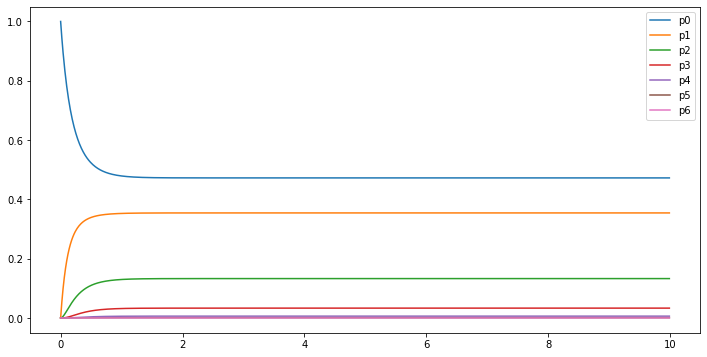

In [6]:
plt.figure(figsize=(12,6))
for k in range(n + 1):
    plt.plot(T, Pk[:, k])
plt.legend(['p{}'.format(k) for k in range(n + 1)])

In [7]:
print('Чисельні значення стаціонарних ймовірностей зайнятості k каналів:')
num_p = np.array([Pk[-1, k] for k in range(n + 1)])
for k in range(n + 1):
    print('p{}* = {}'.format(k, num_p[k]))

Чисельні значення стаціонарних ймовірностей зайнятості k каналів:
p0* = 0.4723730663164618
p1* = 0.3542797997373457
p2* = 0.1328549249015044
p3* = 0.033213731225376075
p4* = 0.0062275746047580115
p5* = 0.0009341361907137016
p6* = 0.00011676702383921267


In [8]:
# 4. Розрахувати теоретичні ймовірності pk* зайнятості числа каналів за фор-
# мулами Ерланга

def erlang_p(l, m, k):
    a = l / m
    return ((a ** k) / np.math.factorial(k)) /\
           np.sum([(a ** k) / np.math.factorial(k) for k in range(n + 1)])
p_teor = np.array([erlang_p(l, m, k) for k in range(n + 1)])
for k in range(n + 1):
    print('p{}* = {}'.format(k, p_teor[k]))

p0* = 0.47237306631646164
p1* = 0.35427979973734625
p2* = 0.13285492490150483
p3* = 0.03321373122537621
p4* = 0.006227574604758039
p5* = 0.0009341361907137058
p6* = 0.00011676702383921323


In [9]:
def model(l, m, n, T):
    tin = [np.random.exponential(1 / l)]
    while tin[-1] < T:
        tin.append(tin[-1] + np.random.exponential(1 / l))
    tin = np.array(tin) # Масив часових міток надходження заявок
    tout = np.zeros(tin.shape) # Масив часових міток відпущення заявок
    tservice = np.random.exponential(1 / m, tin.shape) # Час обслуговування
    in_service = [] # Список заявок на обслуговуванні
    in_waiting = [] # Список заявок у черзі

    for i in range(len(tin)):
        for j in in_service: # Звільнити канали, якщо потрібно
            if tin[i] > tout[j]:
                in_service.remove(j)
                if len(in_waiting) > 0: # Якщо є черга, зайняти вільні канали
                    in_service.append(in_waiting[0])
                    in_waiting.pop(0)
        if len(in_service) < n: # Якщо є вільні канали, виконати поточну
            in_service.append(i)
            tout[i] = tin[i] + tservice[i]
        else: # Поставити поточну заявку в чергу
            if len(in_waiting) == 0:
                first_free = tout[in_service].min()
            else:
                first_free = tout[tout > tout[i - 1] - tservice[i - 1]].min()
            tout[i] = first_free + tservice[i]
            in_waiting.append(i)
            
    taccept = tout - tservice
    taccept = np.concatenate([[taccept], [np.ones(taccept.shape[0])]])
    taccept = taccept.T # Час прийняття на обслуговування
    tout = np.concatenate([[tout], [np.ones(tout.shape[0]) * -1]])
    tout = tout.T
    general_flow = np.concatenate([taccept, tout])
    general_flow = general_flow[general_flow[:, 0].argsort()]
    general_flow[:, 1] = np.cumsum(general_flow[:, 1])
    x = general_flow[:, 0]
    y = general_flow[:, 1].astype(np.int64)
    return (x, y)

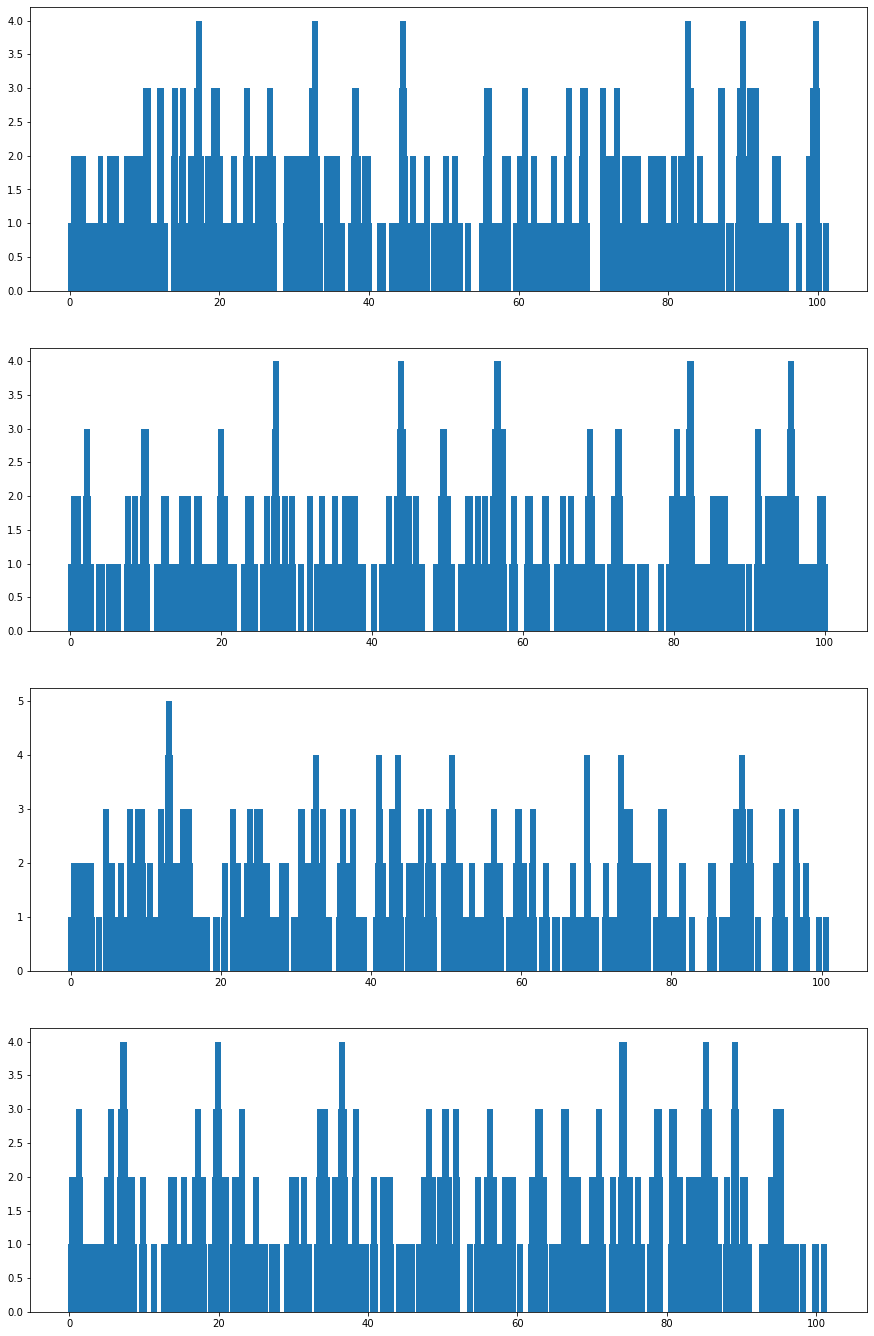

In [10]:
fig, ax = plt.subplots(nrows = 4, figsize=(15, 24))
for axi in ax:
    x, y =  model(l, m, n, 100)
    axi.bar(x, y)

In [11]:
x, y =  model(l, m, n, 1000)
hist = np.zeros(n + 1)
for i in range(len(x) - 1):
    hist[y[i]] += x[i + 1] - x[i]
p_exp = hist / x.max()
print('Експериментальні значення стаціонарних ймовірностей зайнятості k каналів:')
for k in range(n + 1):
    print('p{}* = {}'.format(k, p_exp[k]))

Експериментальні значення стаціонарних ймовірностей зайнятості k каналів:
p0* = 0.4700698284780513
p1* = 0.3506503862277219
p2* = 0.13344485367309183
p3* = 0.03864283719894418
p4* = 0.006154374927069728
p5* = 0.0008086359598819859
p6* = 0.0


In [12]:
# 6.  Порівняти  отримані  експериментальні  й  теоретичні  значення  ймовір-
# ностей.

err = np.abs(p_teor - p_exp)
print('Відхилення теоретичних ймовірностей від експериментальних:')
for k in range(n + 1):
    print('e(p{}*) = {}'.format(k, err[k]))

Відхилення теоретичних ймовірностей від експериментальних:
e(p0*) = 0.0023032378384103547
e(p1*) = 0.0036294135096243685
e(p2*) = 0.0005899287715870061
e(p3*) = 0.005429105973567973
e(p4*) = 7.31996776883112e-05
e(p5*) = 0.0001255002308317199
e(p6*) = 0.00011676702383921323


In [13]:
# 7. Знайти основні характеристики СМО в стаціонарному режимі.

p_decl = p_teor[n]
q = 1 - p_decl
A = l * q
k_aver = np.sum([((l / m) ** k) * p_teor[0] / np.math.factorial(k - 1)
                 for k in range(1, n + 1)])

print('1) імовірність відмови черговій заявці в обслуговуванні: ',
      p_teor[n])
print('2) імовірність того, що заявка буде прийнята на \
обслуговування (відносна пропускна здатність): ',
      1 - p_teor[n])
print('3) абсолютна пропускна здатність: ', A)
print('4) середнє число каналів, зайнятих обслуговуванням', k_aver)
print('5) імовірність того, що всі канали вільні: ', p_teor[0])
print('6) імовірність того, що в системі перебуває рівно  k  вимог, \
тобто зайнято k  каналів:')
for k in range(1, n + 1):
    print('p{}* = {}'.format(k, p_teor[k]))

1) імовірність відмови черговій заявці в обслуговуванні:  0.00011676702383921323
2) імовірність того, що заявка буде прийнята на обслуговування (відносна пропускна здатність):  0.9998832329761608
3) абсолютна пропускна здатність:  2.9996496989284824
4) середнє число каналів, зайнятих обслуговуванням 0.7499124247321204
5) імовірність того, що всі канали вільні:  0.47237306631646164
6) імовірність того, що в системі перебуває рівно  k  вимог, тобто зайнято k  каналів:
p1* = 0.35427979973734625
p2* = 0.13285492490150483
p3* = 0.03321373122537621
p4* = 0.006227574604758039
p5* = 0.0009341361907137058
p6* = 0.00011676702383921323
